In [2]:
import os

from dotenv import load_dotenv
from langchain_groq import ChatGroq
from langchain.tools import tool

load_dotenv()

os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

In [71]:
model = ChatGroq(model="deepseek-r1-distill-llama-70b",
                   temperature=0.1,
                   max_tokens=500)

model.invoke("Latentview analytics").content

'<think>\n\n</think>\n\nLatentView Analytics is a leading analytics and business intelligence firm that specializes in helping organizations leverage data to make informed decisions. The company provides a range of services, including data analytics, business intelligence, predictive analytics, and big data solutions. Here are some key aspects of LatentView Analytics:\n\n1. **Data Analytics**: LatentView helps organizations analyze and interpret complex data sets to uncover insights that drive business performance. This includes descriptive, diagnostic, predictive, and prescriptive analytics.\n\n2. **Business Intelligence**: The company offers BI solutions that enable businesses to transform raw data into actionable insights. This includes reporting, dashboards, and KPI tracking.\n\n3. **Predictive Analytics**: LatentView uses advanced statistical techniques and machine learning algorithms to forecast future trends and behaviors, helping businesses anticipate and prepare for upcoming c

In [72]:
import os
from langchain_community.tools.tavily_search import TavilySearchResults
TAVILY_API_KEY=os.getenv("TAVILY_API_KEY")
search_tool=TavilySearchResults(tavily_api_key=TAVILY_API_KEY)

In [73]:
tool.invoke("What is the capital of France?")

AttributeError: 'function' object has no attribute 'invoke'

In [ ]:
code = """
x = 10
y = 20
z = x + y
print(z)
"""

In [ ]:
from langchain_experimental.utilities import PythonREPL

In [ ]:
repl = PythonREPL()
repl.run(code)

'30\n'

In [ ]:
from typing import Annotated
from langchain_core.tools import tool

@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    
    result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )

In [ ]:
print(python_repl_tool.invoke(code))

Successfully executed:
\`\`\`python

x = 10
y = 20
z = x + y
print(z)

\`\`\`
Stdout: 30


If you have completed all tasks, respond with FINAL ANSWER.


In [ ]:
members = ["researcher", "coder"]

options = members + ["FINISH"]

In [74]:
from typing import Literal
from typing_extensions import TypedDict

class Router(TypedDict):
    next: Literal['researcher','coder','FINISH']

In [75]:
from langgraph.graph import MessagesState, StateGraph, START, END

class State(MessagesState):
    next:str

In [76]:
system_prompt = f"""
You are a supervisor tasked with managing a conversation between the
following workers: {members}. Given the following user request,
respond with the worker to act next. Each worker will perform a
task and respond with their results and status. When finished,
respond with FINISH.
"""

In [77]:
from langgraph.types import Command

def supervisor_agent(state:State)->Command[Literal['researcher', 'coder', '__end__']]:
    
    messages = [{"role": "system", "content": system_prompt},] + state["messages"]
    
    llm_with_structure_output=model.with_structured_output(Router)
    
    response=llm_with_structure_output.invoke(messages)
    
    #this is my next worker agent
    goto=response["next"]
    
    print("**********BELOW IS MY GOTO***************")
    
    print(goto)
    
    if goto == "FINISH":
        goto=END
        
    return Command(goto=goto, update={"next":goto})

In [78]:
from langgraph.prebuilt import create_react_agent
from langchain_core.messages import HumanMessage

def research_agent(state: State) -> Command[Literal["supervisor"]]:
    
    research_agent = create_react_agent(model, tools=[search_tool], prompt="You are a researcher. DO NOT do any math.")
    
    result=research_agent.invoke(state)
    
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="researcher")
            ]
        },
        goto="supervisor",
    )

In [79]:
def coder_agent(state:State)->Command[Literal['supervisor']]:
    code_agent=create_react_agent(model,tools=[python_repl_tool], prompt="You are a coder. DO NOT do any research.")
    result=code_agent.invoke(state)
    
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="coder")
            ]
        },
        goto="supervisor",
    )
    

In [80]:
graph = StateGraph(State)

In [81]:
graph.add_node("supervisor", supervisor_agent)
graph.add_node("researcher", research_agent)
graph.add_node("coder", coder_agent)

graph.add_edge(START, "supervisor")

In [82]:
app = graph.compile()

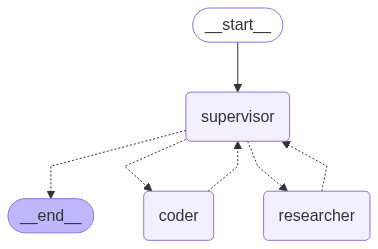

In [83]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

In [84]:
for s in app.stream({"messages": [("user", "What's the square root of 42?")]}, subgraphs=True):
    print(s)
    print("**********BELOW IS MY STATE***************")

**********BELOW IS MY GOTO***************
researcher
((), {'supervisor': {'next': 'researcher'}})
**********BELOW IS MY STATE***************
(('researcher:3b9033a3-97c2-e4bf-2654-03424707857e',), {'agent': {'messages': [AIMessage(content='The square root of 42 is approximately 6.48.', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 300, 'prompt_tokens': 179, 'total_tokens': 479, 'completion_time': 1.0909090909999999, 'prompt_time': 0.012453157, 'queue_time': 0.060959335999999996, 'total_time': 1.103362248}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'stop', 'logprobs': None}, id='run--86082bf6-c7a4-4c86-9657-a05f0de8c9a7-0', usage_metadata={'input_tokens': 179, 'output_tokens': 300, 'total_tokens': 479})]}})
**********BELOW IS MY STATE***************
((), {'researcher': {'messages': [HumanMessage(content='The square root of 42 is approximately 6.48.', additional_kwargs={}, response_metadata={}, na